We'll analyze how different financial assets (such as digital currencies and other investments) relate to each other. The goal is to see if they "go together" (if they're correlated) and whether it's possible to group them into sets that behave similarly.

In [10]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

The data can be obtained from pre-built files or downloaded from the internet. They are essentially lists of asset prices over time. Here, we'll use real data for some crypto assets from January 30, 2020, to November 29, 2024. The data is located in the data folder. To reduce noise, we compare two time windows in the time series: 1 day and 30 days.

In [11]:
folder_path = "/content/"

# Detects whether we are in Colab or running locally
IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    folder_path = "/content/"
else:
    cwd = Path.cwd()
    if cwd.name == "notebooks":
        project_root = cwd.parent
    else:
        project_root = cwd

    data_dir = project_root / "data"
    if not data_dir.exists():
        raise FileNotFoundError(f"Data folder not found: {data_dir}\n.")
    folder_path = str(data_dir) + os.sep

print("USANDO folder_path =", folder_path)
try:
    print("Files in data/:", list(os.listdir(folder_path))[:20])
except Exception as e:
    print("Error/:", e)

close_prices = {}
returns_list = []
returns_30d_list = []

for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Extract currency name from file name
        coin_name = os.path.splitext(file)[0]
        coin_name = coin_name.split('_')[0]

        df = pd.read_csv(os.path.join(folder_path, file))

        # Ensure dates are sorted correctly
        df['Start'] = pd.to_datetime(df['Start'])
        df = df.sort_values(by='Start')

        # Store closing data
        close_prices[coin_name] = df.set_index('Start')['Close']

        # Calculate daily returns from closing price
        df['daily_return'] = df['Close'].pct_change()
        df['daily_return_5'] = df['Close'].pct_change(periods=30)

        # Store daily returns and currency name
        returns_list.append((coin_name, df[['Start', 'daily_return']])) # 1 day
        returns_30d_list.append((coin_name, df[['Start', 'daily_return']])) # 30 days

close_df = pd.DataFrame(close_prices)

final_df = pd.DataFrame()
for coin_name, data in returns_list:
    data = data.set_index('Start')
    final_df[coin_name] = data['daily_return']
final_df = final_df.T

final_30d_df = pd.DataFrame()
for coin_name, data in returns_30d_list:
    data = data.set_index('Start')
    final_30d_df[coin_name] = data['daily_return']
final_30d_df = final_30d_df.T

print(final_df.head())

USANDO folder_path = /content/
Files in data/: ['.config', 'cosmos_2020-01-30_2024-11-29.csv', 'cardano_2020-01-30_2024-11-29.csv', 'litecoin_2020-01-30_2024-11-29.csv', 'algorand_2020-01-30_2024-11-29.csv', 'ethereum_2020-01-30_2024-11-29.csv', 'dogecoin_2020-01-30_2024-11-29.csv', 'ripple_2020-01-30_2024-11-29.csv', 'stellar_2020-01-30_2024-11-29.csv', 'matic-network_2020-01-30_2024-11-29.csv', 'bitcoin_2020-01-30_2024-11-29.csv', 'binance-coin_2020-01-30_2024-11-29.csv', 'sample_data']
Start     2020-01-30  2020-01-31  2020-02-01  2020-02-02  2020-02-03  \
cosmos           NaN   -0.004826   -0.001294    0.007263   -0.031945   
cardano          NaN   -0.039473    0.043737   -0.007024    0.024559   
litecoin         NaN   -0.006469    0.048159   -0.007724   -0.008539   
algorand         NaN    0.031136   -0.002149    0.024521    0.027930   
ethereum         NaN   -0.025969    0.022987    0.026486    0.006982   

Start     2020-02-04  2020-02-05  2020-02-06  2020-02-07  2020-02-08  ...

Before we begin our analysis, we take a quick look at the data to ensure everything appears accurate, the dates are correct, the numbers are consistent, and there's no missing information.

Columns available in DataFrame: Index(['cosmos', 'cardano', 'litecoin', 'algorand', 'ethereum', 'dogecoin',
       'ripple', 'stellar', 'matic-network', 'bitcoin', 'binance-coin'],
      dtype='object')


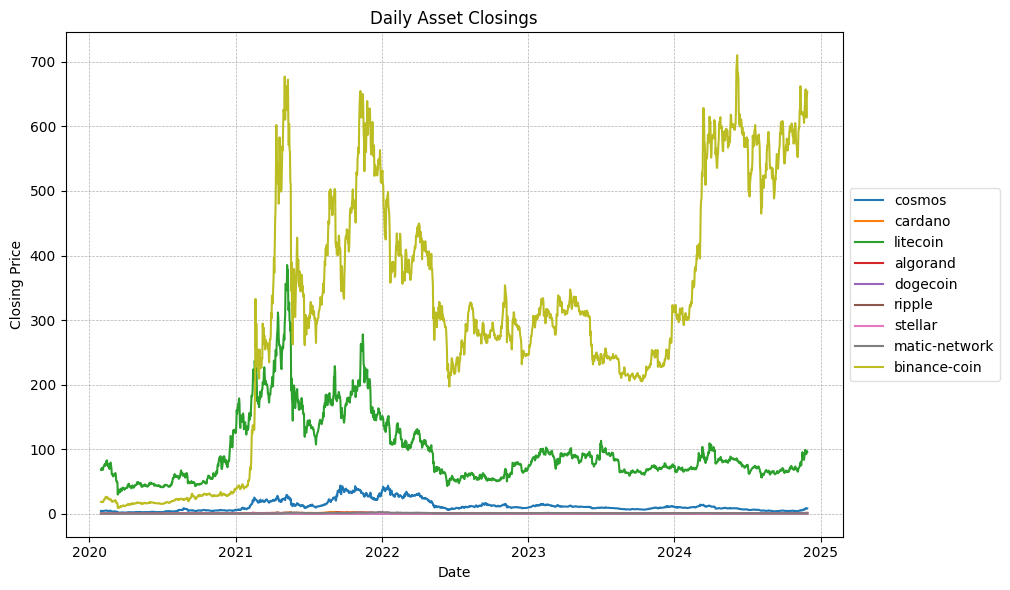

In [12]:
import matplotlib.pyplot as plt

print("Columns available in DataFrame:", close_df.columns)

excluded_coins = ["bitcoin", "ethereum"]

plt.figure(figsize=(12, 6))
for coin in close_df.columns:
    if coin.strip().lower() not in excluded_coins:
        plt.plot(close_df.index, close_df[coin], label=coin)

plt.title("Daily Asset Closings")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.6)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

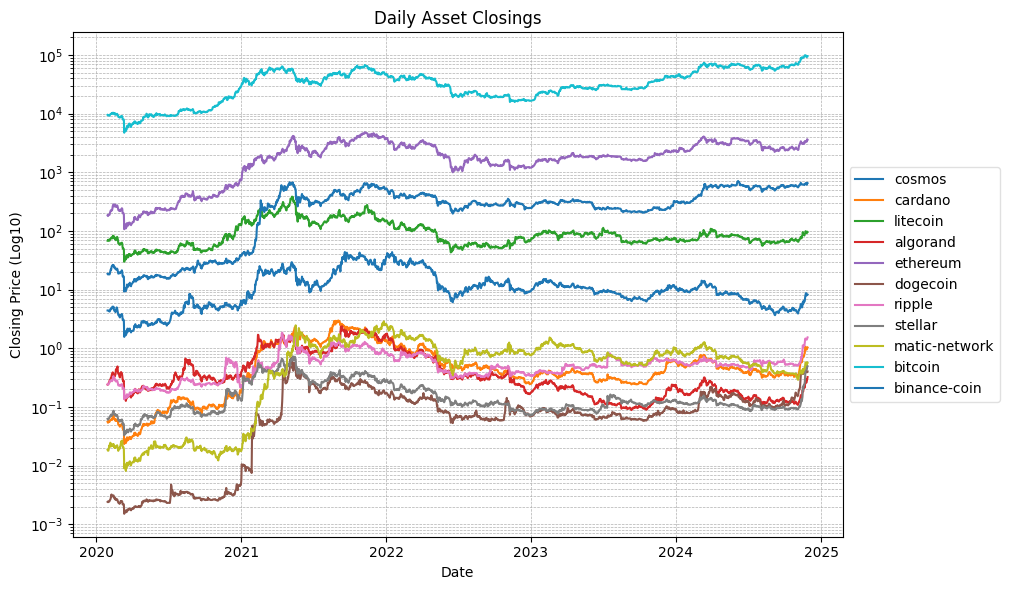

In [13]:
plt.figure(figsize=(12, 6))
for coin in close_df.columns:
    plt.plot(close_df.index, close_df[coin], label=coin)

plt.yscale('log')

plt.title("Daily Asset Closings")
plt.xlabel("Date")
plt.ylabel("Closing Price (Log10)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.6)  # Posiciona a legenda fora do gráfico
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Reduz o espaço do gráfico para dar lugar à legenda
plt.show()

Here, we've organized the data to facilitate more straightforward calculations. Each asset is in a column, and each row corresponds to a specific day, allowing us to compare them all over the same period.

In [14]:
final_df.dropna(axis=1, how='all', inplace=True)
final_30d_df.dropna(axis=1, how='all', inplace=True)

If any price value is missing, we complete the information based on the next few days or remove that line.

In [15]:
has_nan = final_df.isna().any().any()
print("There are NaN values ​​in the dataframe:", has_nan)
has_nan = final_30d_df.isna().any().any()
print("There are NaN values ​​in the dataframe:", has_nan)

There are NaN values ​​in the dataframe: False
There are NaN values ​​in the dataframe: False


In [16]:
print("DataFrame Index:", final_df.index)
print("First rows of the DataFrame:\n", final_df.head())

DataFrame Index: Index(['cosmos', 'cardano', 'litecoin', 'algorand', 'ethereum', 'dogecoin',
       'ripple', 'stellar', 'matic-network', 'bitcoin', 'binance-coin'],
      dtype='object')
First rows of the DataFrame:
 Start     2020-01-31  2020-02-01  2020-02-02  2020-02-03  2020-02-04  \
cosmos     -0.004826   -0.001294    0.007263   -0.031945   -0.011205   
cardano    -0.039473    0.043737   -0.007024    0.024559   -0.019990   
litecoin   -0.006469    0.048159   -0.007724   -0.008539   -0.022702   
algorand    0.031136   -0.002149    0.024521    0.027930    0.076627   
ethereum   -0.025969    0.022987    0.026486    0.006982   -0.005920   

Start     2020-02-05  2020-02-06  2020-02-07  2020-02-08  2020-02-09  ...  \
cosmos      0.022808    0.059602    0.044520   -0.028455    0.022389  ...   
cardano     0.058020    0.013522    0.001662   -0.002596    0.031907  ...   
litecoin    0.065156    0.014064    0.013876    0.028605    0.004220  ...   
algorand   -0.019430    0.046776    0.079

In [17]:
final_df = final_df.transpose()
final_30d_df = final_30d_df.transpose()

Here, we create graphs to visualize how prices and returns change over time. These graphs help identify patterns, sudden drops, upswings, or periods of stability.

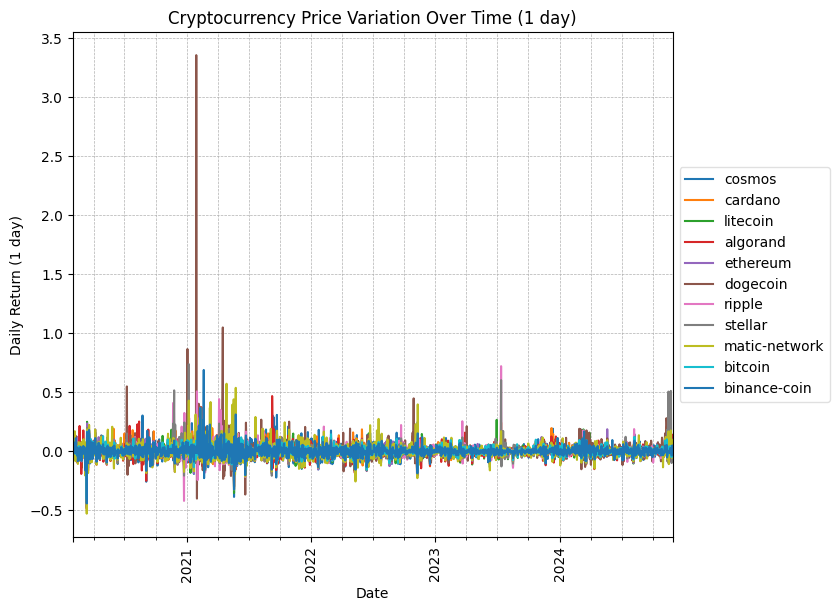

In [18]:
from matplotlib.dates import DateFormatter
final_df.plot(figsize=(10, 6))

plt.title('Cryptocurrency Price Variation Over Time (1 day)')
plt.xlabel('Date')
plt.ylabel('Daily Return (1 day)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.6)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

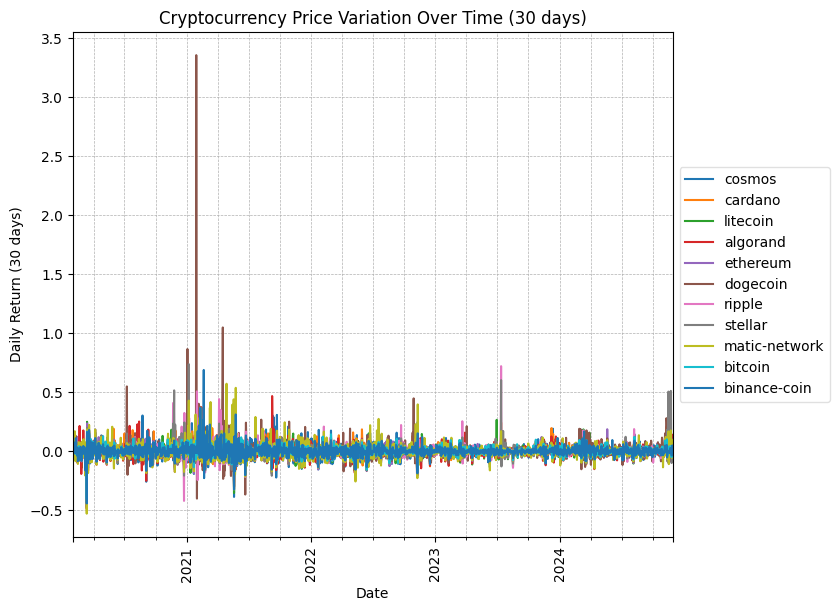

In [19]:
final_30d_df.plot(figsize=(10, 6))

plt.title('Cryptocurrency Price Variation Over Time (30 days)')
plt.xlabel('Date')
plt.ylabel('Daily Return (30 days)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.6)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Here, we ask the computer to categorize assets into groups based on their similar behavior. This way, we can identify which assets form cliques because they move similarly.

In [20]:
final_df = final_df.transpose()
final_30d_df = final_30d_df.transpose()

In [21]:
data = final_df.values
print(data)
data_30d = final_30d_df.values
print(data_30d)

[[-4.82599697e-03 -1.29357213e-03  7.26327183e-03 ...  9.17016703e-03
   4.04887901e-02 -1.09212421e-02]
 [-3.94731666e-02  4.37366333e-02 -7.02386994e-03 ...  1.44270524e-02
   5.47213005e-02  1.93588768e-02]
 [-6.46907467e-03  4.81586991e-02 -7.72415725e-03 ...  4.30654367e-03
   4.84358755e-02 -1.57813446e-02]
 ...
 [-3.46093671e-02 -5.99204150e-05  6.95418086e-02 ... -5.61021201e-02
   9.72905517e-02 -2.46104561e-02]
 [-1.75871201e-02  5.35261950e-03 -4.95740877e-03 ... -1.16722588e-02
   4.24666079e-02 -2.79280908e-03]
 [-2.38061812e-02  3.36772870e-03  1.47599400e-02 ... -3.48256390e-02
   5.03473824e-02  1.48803325e-02]]
[[-4.82599697e-03 -1.29357213e-03  7.26327183e-03 ...  9.17016703e-03
   4.04887901e-02 -1.09212421e-02]
 [-3.94731666e-02  4.37366333e-02 -7.02386994e-03 ...  1.44270524e-02
   5.47213005e-02  1.93588768e-02]
 [-6.46907467e-03  4.81586991e-02 -7.72415725e-03 ...  4.30654367e-03
   4.84358755e-02 -1.57813446e-02]
 ...
 [-3.46093671e-02 -5.99204150e-05  6.9541808

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaler_data_30d = StandardScaler()
scaled_data_30d = scaler.fit_transform(data_30d)

We tested different numbers of clusters and used a measure that indicates which division is clearest. This way, we found the number of clusters that best represent the reality of the data. To do this, we used two models.

* **Silhouette**: measures how well each asset fits within its cluster. A high score indicates that the assets in the cluster are truly similar to each other and distinct from those in other clusters.
\begin{equation}
s(i) = \frac{b(i)−a(i)}{max\,{a(i),b(i)}}
\end{equation}
where $a(i)$ is the average distance from point $i$ to all points in the same cluster. $b(i)$ is the smallest average distance from point i to points in another, nearest neighboring cluster.

* **Gap Statistic**: compares the clusters we found with a completely random division. If the difference is large, it means the clusters the computer found are significant and not just a coincidence. \begin{equation}
Gap(k)=E∗[log(W_k∗​)]−log(W_k​)
\end{equation}
where $W_k$ is equal to the sum of the distances within the groups (the smaller, the better clustered). $E^∗[log⁡(W_k^∗)]$ is the expected value of these distances in a simulated random set.

These two methods, when combined, help increase confidence that the number of groups chosen truly reflects real patterns in the data.

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def gap_statistics_for_datasets(datasets, kmax=10, n_refs=5, random_state=42, plot=True):

    rng = np.random.RandomState(random_state)

    # normalize input formats to dict
    if isinstance(datasets, np.ndarray):
        datasets = {"data": datasets}
    elif isinstance(datasets, list):
        datasets = {f"data_{i}": d for i, d in enumerate(datasets)}
    elif not isinstance(datasets, dict):
        raise ValueError("Datasets must be a numpy array, a list of arrays, or a dict name->array")

    resultados = {}

    for name, X in datasets.items():
        X = np.asarray(X)
        gaps = np.zeros(kmax - 1)

        for k in range(1, kmax):
            # total intra-cluster distance to the real data
            kmeans = KMeans(n_clusters=k, random_state=random_state).fit(X)
            labels = kmeans.labels_
            dist = 0.0
            for i in range(k):
                cluster_points = X[labels == i]
                if cluster_points.shape[0] == 0:
                    continue
                _, dists = pairwise_distances_argmin_min(cluster_points, kmeans.cluster_centers_[i:i+1])
                dist += dists.sum()

            # average distance for random data (multiple references to reduce variance)
            dist_randoms = []
            for b in range(n_refs):
                random_data = rng.random_sample(size=X.shape)
                kmeans_random = KMeans(n_clusters=k, random_state=random_state + b + 1).fit(random_data)
                labels_random = kmeans_random.labels_
                dist_r = 0.0
                for i in range(k):
                    pts = random_data[labels_random == i]
                    if pts.shape[0] == 0:
                        continue
                    _, dists_r = pairwise_distances_argmin_min(pts, kmeans_random.cluster_centers_[i:i+1])
                    dist_r += dists_r.sum()
                dist_randoms.append(dist_r)

            # use log of mean of random distances
            mean_log_dist_random = np.log(np.mean(dist_randoms))
            log_dist = np.log(dist) if dist > 0 else -np.inf  # avoid log(0)
            gaps[k-1] = mean_log_dist_random - log_dist

        best_k = int(np.argmax(gaps) + 1)  # +1 because gaps[0] corresponds to k=1
        resultados[name] = {"gaps": gaps, "best_k": best_k}

    if plot:
        plt.figure(figsize=(9, 6))
        ks = np.arange(1, kmax)
        for name, info in resultados.items():
            plt.plot(ks, info["gaps"], marker='o', label=f"{name} (k*={info['best_k']})")
        plt.title("Gap Statistic por dataset")
        plt.xlabel("Number of Clusters (k)")
        plt.xticks(ks)
        plt.ylabel("Gap Statistic")
        plt.grid(True)
        plt.legend()
        plt.show()

    return resultados

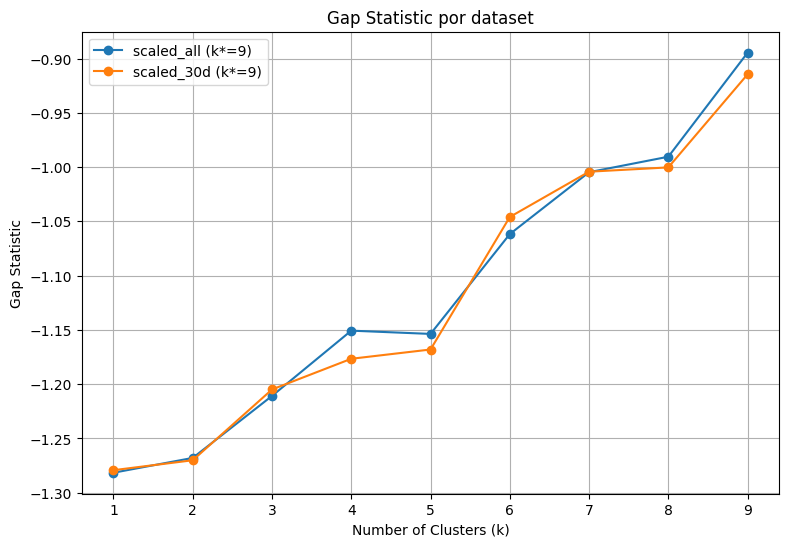

Best k scaled_all: 9
Best k scaled_30d: 9


In [24]:
datasets = {
    "scaled_all": scaled_data,
    "scaled_30d": scaled_data_30d
}
results = gap_statistics_for_datasets(datasets, kmax=10, n_refs=10, random_state=42, plot=True)

# acessar resultados
print("Best k scaled_all:", results["scaled_all"]["best_k"])
print("Best k scaled_30d:", results["scaled_30d"]["best_k"])


In [25]:
from sklearn.metrics import silhouette_score

def silhouette_for_datasets(datasets, k_range=range(2, 11), random_state=42, plot=True):

    if isinstance(datasets, np.ndarray):
        datasets = {"data": datasets}
    elif isinstance(datasets, list):
        datasets = {f"data_{i}": d for i, d in enumerate(datasets)}
    elif not isinstance(datasets, dict):
        raise ValueError("Datasets must be a numpy array, a list of arrays, or a dict name->array")

    resultados = {}

    for name, X in datasets.items():
        scores = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=random_state)
            labels = kmeans.fit_predict(X)
            score = silhouette_score(X, labels)
            scores.append(score)

        best_k = k_range[np.argmax(scores)]
        resultados[name] = {"scores": scores, "best_k": best_k}

    if plot:
        plt.figure(figsize=(9, 6))
        for name, info in resultados.items():
            plt.plot(list(k_range), info["scores"], marker='o', label=f"{name} (k*={info['best_k']})")
        plt.title("Silhouette Score by dataset")
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Silhouette Score")
        plt.xticks(list(k_range))
        plt.grid(True)
        plt.legend()
        plt.show()

    return resultados

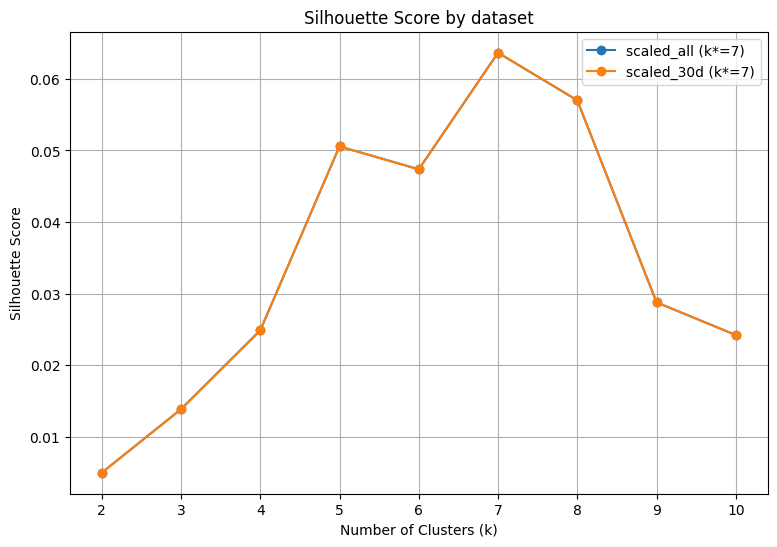

Best k scaled_all: 7
Best k scaled_30d: 7


In [26]:
datasets = {
    "scaled_all": scaled_data,
    "scaled_30d": scaled_data_30d
}

silhouette_results = silhouette_for_datasets(datasets, k_range=range(2, 11), random_state=42, plot=True)

print("Best k scaled_all:", silhouette_results["scaled_all"]["best_k"])
print("Best k scaled_30d:", silhouette_results["scaled_30d"]["best_k"])


With the clustering values ​in hand, let's observe the clustering behavior in relation to the daily return in two dimensions.

                        Coin  Cluster
cosmos                cosmos        2
cardano              cardano        4
litecoin            litecoin        0
algorand            algorand        5
ethereum            ethereum        0
dogecoin            dogecoin        6
ripple                ripple        1
stellar              stellar        1
matic-network  matic-network        3
bitcoin              bitcoin        0
binance-coin    binance-coin        0


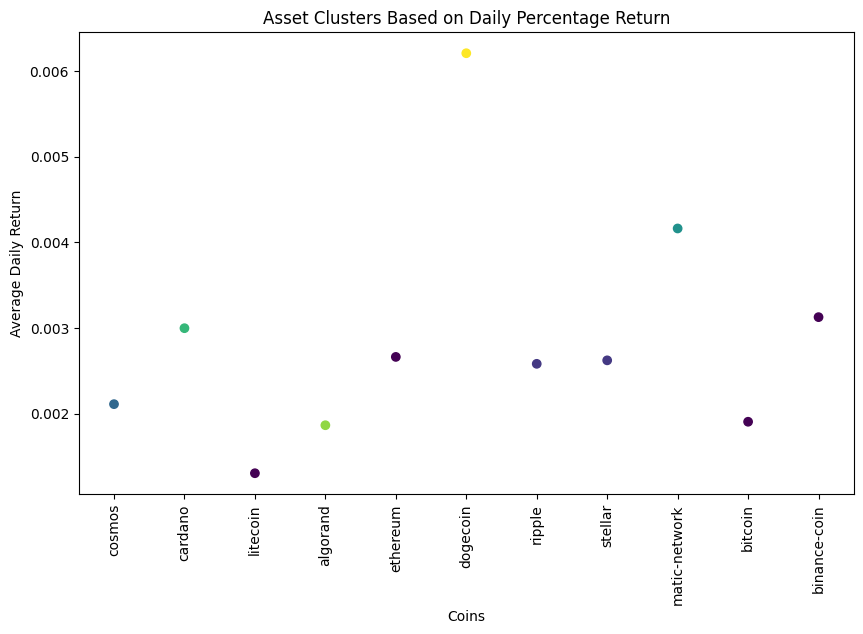

In [27]:
kmeans = KMeans(n_clusters=7, random_state=42)
final_df['Cluster'] = kmeans.fit_predict(scaled_data)

coins_clusters_df = pd.DataFrame({
    'Coin': final_df.index,
    'Cluster': final_df['Cluster']
})

print(coins_clusters_df)

plt.figure(figsize=(10, 6))
plt.scatter(final_df.index, final_df.iloc[:, :-1].mean(axis=1), c=final_df['Cluster'], cmap='viridis')
plt.xlabel('Coins')
plt.ylabel('Average Daily Return')
plt.title('Asset Clusters Based on Daily Percentage Return')
plt.xticks(rotation=90)
plt.show()

It doesn't provide much information, does it?! Although Dogecoin stood out with the highest average return over the analyzed timeframe. Let's reduce the complexity by extracting the most informative features using Principal Component Analysis (PCA).

In [28]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])

if len(pca_df) == len(final_df):
    pca_df['Cluster'] = final_df['Cluster'].values
    pca_df['Coin'] = final_df.index
else:
    print("Error: The number of lines of pca_df and final_df does not match.")

print(pca_df)


         PCA1       PCA2       PCA3  Cluster           Coin
0  -32.860532 -18.335594  17.174946        2         cosmos
1   -3.788759  -0.759785  -0.308284        4        cardano
2   12.206417   3.864431   6.042518        0       litecoin
3  -24.915735 -15.204172   0.226900        5       algorand
4    7.206125   7.278285  -0.697029        0       ethereum
5   19.249996 -30.247698 -30.038792        6       dogecoin
6   14.641560   7.335097  15.443693        1         ripple
7    7.080308   4.833908  16.086504        1        stellar
8  -25.629064  30.131312 -27.133816        3  matic-network
9   16.575995   2.429281   1.602186        0        bitcoin
10  10.233690   8.674935   1.601175        0   binance-coin


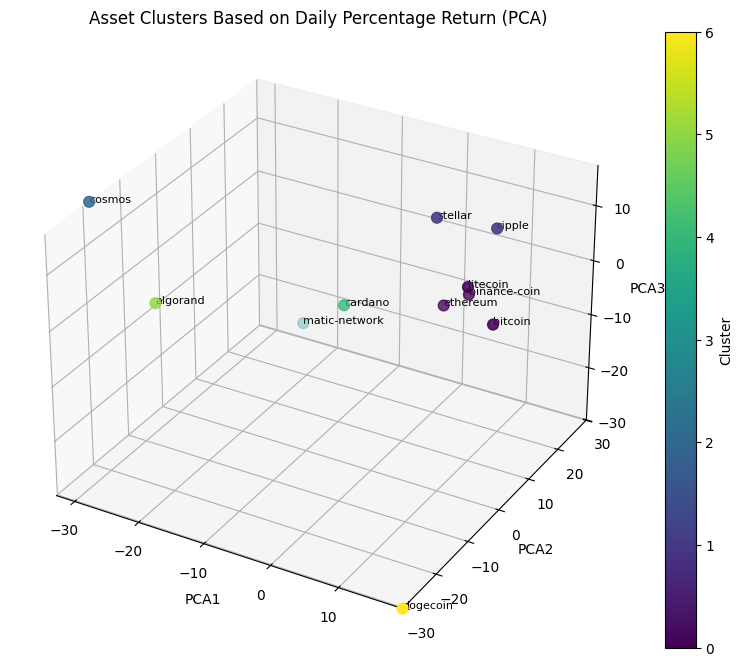

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=pca_df['Cluster'], cmap='viridis', s=60)

for i, coin in enumerate(pca_df['Coin']):
    ax.text(pca_df['PCA1'].iloc[i], pca_df['PCA2'].iloc[i], pca_df['PCA3'].iloc[i], coin, size=8, zorder=2)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Asset Clusters Based on Daily Percentage Return (PCA)')

plt.colorbar(sc, label='Cluster')

ax.set_xlim([pca_df['PCA1'].min(), pca_df['PCA1'].max()])
ax.set_ylim([pca_df['PCA2'].min(), pca_df['PCA2'].max()])
ax.set_zlim([pca_df['PCA3'].min(), pca_df['PCA3'].max()])

plt.show()

In [30]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "notebook_connected"

fig = px.scatter_3d(pca_df, x='PCA1', y='PCA2', z='PCA3', color='Cluster',
                    labels={'PCA1': 'PCA1', 'PCA2': 'PCA2', 'PCA3': 'PCA3'},
                    hover_data={'Coin': True}, text='Coin')

fig.update_layout(title='Asset Clusters Based on Daily Percentage Return')
fig.show()

From the figure, we can more clearly observe how clusters are distributed in the daily return space. Based on this analysis, investors can better diversify their portfolios, avoiding assets that demonstrate very similar correlations.